In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
import athena_read as ar
from glob import glob
from Constants import Constants
import planet_wind_utils as pw
import seaborn as sns
c = Constants()
import mesh_tools as mt
import plotly.graph_objects as go 

%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16

Constants defined...


In [2]:
def makesphere(x, y, z, radius, resolution=10):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)


def make_3d_plot_sw(base_dir,filename_out,nxyz=200,mylevel=1):
    orb = pw.read_trackfile(base_dir+"pm_trackfile.dat")
    print( "ORB: ... ", orb.colnames)

    myfile = base_dir+"PW.out1.00010.athdf"

    # NOTE: read @level=None to get full resolution. 
    d = pw.read_data(myfile,orb,
                     level=mylevel,
                     get_cartesian=True,
                     x1_min = 7e10, x1_max = 1.5*sep*c.au
                    )

    t= d['Time']
    rcom,vcom = pw.rcom_vcom(orb,t)
    x2,y2,z2 = pw.pos_secondary(orb,t)
    
    # define a uniform mesh 
    #nxyz = 200
    lim = 0.05*c.au
    xx,yy,zz,r,th,ph = mt.get_uniform_meshgrid(lim,npoints=nxyz,center=[0,0,0])

    # define interpolating functions & get data
    r0_interp = mt.get_interp_function(d,"r0")
    r0_vals = r0_interp((ph,th,r))


    # get a surface mesh object 
    verts,faces, centroids, areas, normals = mt.get_marching_cubes_mesh(xx,yy,zz,r0_vals,0.005,step_size=1)
    verts1,faces1, centroids1, areas1, normals1 = mt.get_marching_cubes_mesh(xx,yy,zz,r0_vals,0.995,step_size=1)

    # Observer vector
    zf = 2.15
    n0 = np.array([-0.7,-1,0.35])
    n0 = n0/np.linalg.norm(n0)
    camera = dict(
        eye=dict(x=n0[0]*zf, y=n0[1]*zf, z=n0[2]*zf)
    )
    #layout = go.Layout(scene=dict(aspectmode='data',camera=camera))
    myrange=np.array([-0.05,0.05])
    myticks = [-0.025,0,0.025]
    layout=go.Layout(scene = dict(xaxis = dict(range=myrange,showgrid=True,showbackground=False,title='x [au]',tickvals=myticks,gridcolor='grey'),
                                  yaxis = dict(range=myrange,showgrid=True,showbackground=False,title='y [au]',tickvals=myticks,gridcolor='grey'),
                                  zaxis = dict(range=myrange,showgrid=True,showbackground=False,title='z [au]',tickvals=myticks,gridcolor='grey'),
                                  aspectmode='data',
                                  camera=camera),
                    margin=dict(r=0, l=0, b=0, t=0) )

    # planet
    xp,yp,zp=makesphere(x2/c.au,y2/c.au,z2/c.au,2*7e9/c.au,resolution=30)
    xs,ys,zs=makesphere(0,0,0,7e10/c.au,resolution=30)

    mycm = 'plasma_r'


    fig = go.Figure(
        data=[go.Mesh3d(
            x=verts[:,0]/c.au,
            y=verts[:,1]/c.au,
            z=verts[:,2]/c.au,
            i=faces[:,0],
            j=faces[:,1],
            k=faces[:,2],
            intensity=np.ones_like(verts[:,0])*0.2,
            cmin=0,cmax=1,
            #cmin=-2e7,cmax=2e7,opacity=1),
            colorscale=mycm,
            opacity=0.6,
            visible=True,showscale=False
            #lighting=dict(ambient=1),
            #lightposition=dict(x=0,y=0,z=0)
        ), 
        go.Mesh3d(
            x=verts1[:,0]/c.au,
            y=verts1[:,1]/c.au,
            z=verts1[:,2]/c.au,
            i=faces1[:,0],
            j=faces1[:,1],
            k=faces1[:,2],
            intensity=np.ones_like(verts1[:,0])*0.8,
            cmin=0,cmax=1,colorscale=mycm,
            opacity=0.6,
            #lighting=dict(ambient=1),
            #lightposition=dict(x=0,y=0,z=0),
            visible=True,showscale=False
             ),


             go.Surface(x=xp,y=yp,z=zp,
                      showscale=False,
                      surfacecolor=np.zeros_like(zp),
                      colorscale='Reds',
                      lighting=dict(ambient=1)),
              go.Surface(x=xs,y=ys,z=zs,
                      showscale=False,
                      surfacecolor=np.zeros_like(zs),
                      colorscale='Reds',
                      lighting=dict(ambient=1)),
             ],
         layout=layout)

    fig.show()
    #fig.write_image(filename_out)
    
    
def make_3d_plot_new(base_dir,filename_out,nxyz=200,mylevel=1,sep=0.025,mylev=[-16.5,-17,-17.5]):
    orb = pw.read_trackfile(base_dir+"pm_trackfile.dat")
    print( "ORB: ... ", orb.colnames)

    myfile = base_dir+"PW.out1.00003.athdf"

    # NOTE: read @level=None to get full resolution. 
    d = pw.read_data(myfile,orb,
                     level=mylevel,
                     get_cartesian=True,
                     x1_min = 7e10, x1_max = sep*4.5*c.au
                    )

    t= d['Time']
    rcom,vcom = pw.rcom_vcom(orb,t)
    x2,y2,z2 = pw.pos_secondary(orb,t)
    
    d['rho0'] = np.where( d['r0']>0.5, d['rho']*d['r0'], 0.0)
    
    # define a uniform mesh 
    #nxyz = 200
    lim = 3*sep*c.au
    xx,yy,zz,r,th,ph = mt.get_uniform_meshgrid(lim,npoints=nxyz,center=[0,0,0])

    # define interpolating functions & get data
    rho0_interp = mt.get_interp_function(d,"rho0")
    rho0_vals = rho0_interp((ph,th,r))

    # get a surface mesh object 
    verts1,faces1, centroids1, areas1, normals1 = mt.get_marching_cubes_mesh(xx,yy,zz,np.log10(rho0_vals),mylev[0],step_size=1)
    verts2,faces2, centroids2, areas2, normals2 = mt.get_marching_cubes_mesh(xx,yy,zz,np.log10(rho0_vals),mylev[1],step_size=1)
    verts3,faces3, centroids3, areas3, normals3 = mt.get_marching_cubes_mesh(xx,yy,zz,np.log10(rho0_vals),mylev[2],step_size=1)

    # Observer vector
    zf = 2.15
    n0 = np.array([-1,0,0.45])
    n0 = n0/np.linalg.norm(n0)
    camera = dict(
        eye=dict(x=n0[0]*zf, y=n0[1]*zf, z=n0[2]*zf)
    )
    #layout = go.Layout(scene=dict(aspectmode='data',camera=camera))
    myrange=np.array([-2*sep,2*sep])
    myticks = [-sep,0,sep]
    layout=go.Layout(scene = dict(xaxis = dict(range=myrange,showgrid=True,showbackground=False,title='x [au]',tickvals=myticks,gridcolor='grey'),
                                  yaxis = dict(range=myrange,showgrid=True,showbackground=False,title='y [au]',tickvals=myticks,gridcolor='grey'),
                                  zaxis = dict(range=myrange,showgrid=True,showbackground=False,title='z [au]',tickvals=myticks,gridcolor='grey'),
                                  #aspectmode='data',
                                  camera=camera),
                    margin=dict(r=0, l=0, b=0, t=0) )
    layout_noax = go.Layout(scene = dict(xaxis = dict(range=myrange,showgrid=False,showbackground=False,title='',tickvals=[],gridcolor='white'),
                                         yaxis = dict(range=myrange,showgrid=False,showbackground=False,title='',tickvals=[],gridcolor='white'),
                                         zaxis = dict(range=myrange,showgrid=False,showbackground=False,title='',tickvals=[],gridcolor='white'),
                                  #aspectmode='data',
                                  camera=camera),
                    margin=dict(r=0, l=0, b=0, t=0) )
    layout_noax2 = go.Layout(scene = dict(xaxis = dict(showgrid=False,showbackground=False,title='',tickvals=[],gridcolor='white'),
                                         yaxis = dict(showgrid=False,showbackground=False,title='',tickvals=[],gridcolor='white'),
                                         zaxis = dict(showgrid=False,showbackground=False,title='',tickvals=[],gridcolor='white'),
                                  aspectmode='data',
                                  camera=camera),
                    margin=dict(r=0, l=0, b=0, t=0) )

    # planet
    xp,yp,zp=makesphere(x2/c.au,y2/c.au,z2/c.au,2*7e9/c.au,resolution=30)
    xs,ys,zs=makesphere(0,0,0,7e10/c.au,resolution=30)

    mycm = 'plasma'


    fig = go.Figure(
        data=[
                go.Mesh3d(
                    x=verts1[:,0]/c.au,
                    y=verts1[:,1]/c.au,
                    z=verts1[:,2]/c.au,
                    i=faces1[:,0],
                    j=faces1[:,1],
                    k=faces1[:,2],
                    intensity=np.ones_like(verts1[:,0])*0.1,
                    cmin=0,cmax=1,colorscale=mycm,
                    opacity=0.6,
                    #lighting=dict(ambient=1),
                    #lightposition=dict(x=0,y=0,z=0),
                    visible=True,showscale=False
                     ),
                  go.Mesh3d(
                    x=verts2[:,0]/c.au,
                    y=verts2[:,1]/c.au,
                    z=verts2[:,2]/c.au,
                    i=faces2[:,0],
                    j=faces2[:,1],
                    k=faces2[:,2],
                    intensity=np.ones_like(verts2[:,0])*0.5,
                    cmin=0,cmax=1,colorscale=mycm,
                    opacity=0.25,
                    #lighting=dict(ambient=1),
                    #lightposition=dict(x=0,y=0,z=0),
                    visible=True,showscale=False
                     ),
                  go.Mesh3d(
                    x=verts3[:,0]/c.au,
                    y=verts3[:,1]/c.au,
                    z=verts3[:,2]/c.au,
                    i=faces3[:,0],
                    j=faces3[:,1],
                    k=faces3[:,2],
                    intensity=np.ones_like(verts3[:,0])*0.9,
                    cmin=0,cmax=1,colorscale=mycm,
                    opacity=0.1,
                    #lighting=dict(ambient=1),
                    #lightposition=dict(x=0,y=0,z=0),
                    visible=True,showscale=False
                     ),

                 go.Surface(x=xp,y=yp,z=zp,
                              showscale=False,
                              surfacecolor=np.zeros_like(zp),
                              colorscale='Reds',
                              lighting=dict(ambient=1)),
                 go.Surface(x=xs,y=ys,z=zs,
                              showscale=False,
                              surfacecolor=np.zeros_like(zs),
                              colorscale='Reds',
                              lighting=dict(ambient=1)),
             ],
        
          layout=layout_noax2) #go.Layout(scene=dict(aspectmode='data')) ) #layout=layout)

    #fig.show()
    fig.write_image(filename_out)
    
    
    
def get_phiL12(d,orb):
    x3ray = np.argmin(np.abs(d['x3v']-np.pi) )
    phi1 = d['PhiEff'][x3ray,0, np.argmax(d['PhiEff'][x3ray,0,d['x1v']<orb['sep'][0]] )]
    phi2 = d['PhiEff'][x3ray,0, np.argmax(d['PhiEff'][x3ray,0,:] )]
    return phi1,phi2

def divV_midplane(d):
    divV = ( d['gx1v']**(-2) *  np.gradient(d['gx1v']**2 * d['vel1'],axis=2,edge_order=2)/np.gradient(d['gx1v'],axis=2,edge_order=2) +
         #1/(d['gx1v']*np.sin(d['gx2v'])) *  np.gradient(np.sin(d['gx2v']) *d['vel2'],axis=1)/np.gradient(d['gx2v'],axis=1) +
         1/(d['gx1v']*np.sin(d['gx2v'])) *  np.gradient(d['vel3'],axis=0,edge_order=2)/np.gradient(d['gx3v'],axis=0,edge_order=2) )
    return divV

def vorticity_midplane(d):
    """phi component of vorticity"""
    vortth = 1/d['gx1v']*(1/np.sin(d['gx2v'])*np.gradient(d['vel1'],axis=0,edge_order=2)/np.gradient(d['gx3v'],axis=0,edge_order=2) - np.gradient(d['gx1v']*d['vel3'],axis=2,edge_order=2)/np.gradient(d['gx1v'],axis=2,edge_order=2) )
    vortz = - np.sin(d['gx2v'])*vortth
    return vortz

In [3]:
make_3d_plot_new('/Users/morganmacleod/DATA/streams_backup/grida/a0.025/l8r2/','figures/3d_stream.pdf',
                 nxyz=200,mylevel=2,sep=0.025,mylev=[-16.5,-17,-17.5])

reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l8r2/PW.out1.00003.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...


/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/4266959116.py:144: RuntimeWarning: divide by zero encountered in log10
  verts1,faces1, centroids1, areas1, normals1 = mt.get_marching_cubes_mesh(xx,yy,zz,np.log10(rho0_vals),mylev[0],step_size=1)
/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/4266959116.py:145: RuntimeWarning: divide by zero encountered in log10
  verts2,faces2, centroids2, areas2, normals2 = mt.get_marching_cubes_mesh(xx,yy,zz,np.log10(rho0_vals),mylev[1],step_size=1)
/Users/morganmacleod/Dropbox/PlanetWind/Analysis/PWMorphology/mesh_tools.py:201: RuntimeWarning: invalid value encountered in divide
  norms = (cp.T/np.linalg.norm(cp,axis=1)).T
/Users/morganmacleod/Dropbox/PlanetWind/Analysis/PWMorphology/mesh_tools.py:203: RuntimeWarning: invalid value encountered in divide
  return (cp.T/np.linalg.norm(cp,axis=1)).T
/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/4266959116.py:146: RuntimeWarning: divide by zero encounter

In [5]:
make_3d_plot_new('/Users/morganmacleod/DATA/streams_backup/grida/a0.05/l2r0.5/','figures/3d_bubble.pdf',
                 nxyz=200,mylevel=2,sep=0.05,mylev=[-19,-20,-21])

reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.05/l2r0.5/PW.out1.00003.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...


/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/4266959116.py:144: RuntimeWarning:

divide by zero encountered in log10

/Users/morganmacleod/Dropbox/PlanetWind/Analysis/PWMorphology/mesh_tools.py:201: RuntimeWarning:

invalid value encountered in divide

/Users/morganmacleod/Dropbox/PlanetWind/Analysis/PWMorphology/mesh_tools.py:203: RuntimeWarning:

invalid value encountered in divide

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/4266959116.py:145: RuntimeWarning:

divide by zero encountered in log10

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/4266959116.py:146: RuntimeWarning:

divide by zero encountered in log10



In [6]:
from astropy.convolution import convolve, Box1DKernel

def get_sigmab(d,sep,rp,nanthresh=1e-13,x1_min_los=7e10):
    b = (d['x3v']-np.pi)*sep
    sigma = np.nansum(np.where(d['gx1v']>x1_min_los,d['r0']*d['rho']*d['gdr'],np.nan),axis=2)[:,0]
    sigma=np.where(sigma>nanthresh,sigma,np.nan)
    #sigma=np.where(np.abs(b)>rp,sigma,0)
    velr = np.nansum(np.where(d['gx1v']>x1_min_los,d['r0']*d['rho']*d['gdr']*-d['vel1'],np.nan),axis=2)[:,0]/sigma
    #velr = (np.sum(-d['vel1']*np.exp(-d['r0']*d['rho']*d['gdr']),axis=2)/np.sum(np.exp(-d['r0']*d['rho']*d['gdr']),axis=2))[:,0]
    sel = np.abs(b)>rp
    return b[sel],sigma[sel],velr[sel]


def read_get_sigmab(base_dir,fn,level,x1_min,x1_max,x3range=np.pi,nanthresh=1.e-13,
                   makeplot=True,x1_min_los=7e10):
    """ read file from directory and compute column values """
    orb = pw.read_trackfile(base_dir+"pm_trackfile.dat")
    x2sliceval = pw.get_midplane_theta(base_dir+fn,level=level)
    sep = orb['sep'][0]

    d = pw.read_data(base_dir+fn,orb,
                     level=level,
                     get_cartesian=True,
                     x2_min=x2sliceval,x2_max=x2sliceval,
                     x1_min = x1_min, 
                     x1_max = x1_max,
                     x3_min = np.pi - x3range,
                     x3_max = np.pi + x3range,
                     gamma=1.0001)
    d1 = d['x1f'][1:] - d['x1f'][:-1]
    d['gdr']=np.broadcast_to(d1,(len(d['x3v']),len(d['x2v']),len(d['x1v'])) )

 
    
    # parse filename to get rp
    rp = int(base_dir[-2:-1])
    rp=np.where(rp==5,0.5,rp)
    rp*=7e9
    
    b,sigma,velr  = get_sigmab(d,sep,rp,nanthresh=nanthresh,x1_min_los=x1_min_los)
  
    return d,sep,b,sigma,velr


def sliceplot(d,sep):
    
    plt.figure(figsize=(5,4) )
    plt.pcolormesh(d['x'][:,0,:]/c.au,
                   d['y'][:,0,:]/c.au,
                   np.log10(d['rho'])[:,0,:] ,
                   cmap=plt.cm.Blues,vmax=-16,vmin=-22)
    plt.colorbar(label=r"$\log_{10} \left( \rho \right)$",extend='both')

    plt.axis('equal')

    lim = sep*2
    plt.xlim(-lim/c.au,lim/c.au)
    plt.ylim(-lim/c.au,lim/c.au)
    plt.xlabel('$x$ [au]')
    plt.ylabel('$y$ [au]')
    #plt.show()
    
    
    
def lineplot(sep,b,sigma,vr):
    db = b[1]-b[0]
    width = 2*c.rsun/db
    sigmac = convolve(sigma,Box1DKernel(width),nan_treatment='fill',fill_value=np.nan)
    vrc = convolve(vr,Box1DKernel(width) ,nan_treatment='fill',fill_value=np.nan)


    plim=7e10/sep/(2*np.pi)*5

    plt.figure()
    plt.subplot(211)
    plt.semilogy(-b/sep/(2*np.pi),sigma,'-',lw=2,color='k')
    plt.semilogy(-b/sep/(2*np.pi),sigmac,'--',lw=2,color='r')
    plt.xlim(-plim,plim)
    plt.xticks(visible=False)
    plt.axvline(0,zorder=0,color='grey')
    plt.axvline(-7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    plt.axvline(7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    plt.ylabel(r"$\Sigma$ [g cm$^{-2}$]")

    plt.subplot(212)
    plt.plot(-b/sep/(2*np.pi),vr/1e5,'-',lw=2,color='k')
    plt.plot(-b/sep/(2*np.pi),vrc/1e5,'--',lw=2,color='r')
    plt.plot(-b/sep/(2*np.pi),np.sin(-b/sep) * np.sqrt( c.G*c.msun/sep ) / 1.e5,zorder=0,label='planet frame' )
    plt.xlim(-plim,plim) 
    plt.axhline(0,ls='--',color='grey',zorder=0)
    plt.axvline(0,zorder=0,color='grey')
    plt.axvline(-7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    plt.axvline(7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    plt.ylim(-30,30)
    plt.ylabel(r"$v_{\rm los}$ [km s$^{-1}$]")
    plt.xlabel('phase')
    
    plt.subplots_adjust(hspace=0)
    #plt.show()    

def makefig(d,sep,b,sigma,vr):

    fig = plt.figure(figsize=(5.5,8))
    f1,f2 = fig.subfigures(nrows=2,ncols=1,height_ratios=[1.5,1])
    f1.subplots()
    plt.pcolormesh(d['x'][:,0,:]/c.au,
                   d['y'][:,0,:]/c.au,
                   #np.log10(d['rho']*d['r0'])[:,0,:] ,
                   np.log10(d['rho'])[:,0,:] ,
                   cmap=plt.cm.magma,vmax=-16,vmin=-22,rasterized=True)
    plt.colorbar(label=r"$\log_{10} \left( \rho \right)$ [g cm$^{-3}$]",extend='both')

    plt.axis('equal')

    lim = sep*2
    plt.xlim(-lim/c.au,lim/c.au)
    plt.ylim(-lim/c.au,lim/c.au)
    plt.xlabel('$x$ [au]')
    plt.ylabel('$y$ [au]')



    db = b[1]-b[0]
    width = 2*c.rsun/db
    sigmac = convolve(sigma,Box1DKernel(width),nan_treatment='fill',fill_value=np.nan)
    vrc = convolve(vr,Box1DKernel(width) ,nan_treatment='fill',fill_value=np.nan)


    plim=7e10/sep/(2*np.pi)*5
    

    a1,a2 = f2.subplots(2,1)
    a1.semilogy(-b/sep/(2*np.pi),sigma,'-',lw=2,color='k')
    a1.semilogy(-b/sep/(2*np.pi),sigmac,'--',lw=2,color='r')
    a1.set_xlim(-plim,plim)
    #a1.set_xticks(visible=False)
    a1.axvline(0,zorder=0,color='grey')
    a1.axvline(-7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a1.axvline(7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a1.set_ylabel(r"$\Sigma$ [g cm$^{-2}$]")


    a2.plot(-b/sep/(2*np.pi),vr/1e5,'-',lw=2,color='k')
    a2.plot(-b/sep/(2*np.pi),vrc/1e5,'--',lw=2,color='r')
    a2.plot(-b/sep/(2*np.pi),np.sin(-b/sep) * np.sqrt( c.G*c.msun/sep ) / 1.e5,zorder=0,label='planet frame' )
    a2.set_xlim(-plim,plim) 
    a2.axhline(0,ls='--',color='grey',zorder=0)
    a2.axvline(0,zorder=0,color='grey')
    a2.axvline(-7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a2.axvline(7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a2.set_ylim(-75,75)
    a2.set_ylabel(r"$\bar v_{\rm los}$ [km s$^{-1}$]")
    a2.set_xlabel('phase')

    f2.subplots_adjust(hspace=0,right=0.8)
    
    
def makefigV(d,sep,b,sigma,vr):

    fig = plt.figure(figsize=(5.5,7))
    f1,f2 = fig.subfigures(nrows=2,ncols=1,height_ratios=[1.8,1])
    f1.subplots()
    plt.pcolormesh(d['x'][:,0,:]/c.au,
                   d['y'][:,0,:]/c.au,
                   #np.log10(d['rho']*d['r0'])[:,0,:] ,
                   np.log10(d['rho'])[:,0,:] ,
                   cmap=plt.cm.magma,vmax=-16,vmin=-22,rasterized=True)
    plt.colorbar(label=r"$\log_{10} \left( \rho \right)$ [g cm$^{-3}$]",extend='both')

    plt.axis('equal')

    lim = sep*2
    plt.xlim(-lim/c.au,lim/c.au)
    plt.ylim(-lim/c.au,lim/c.au)
    plt.xlabel('$x$ [au]')
    plt.ylabel('$y$ [au]')



    db = b[1]-b[0]
    width = 2*c.rsun/db
    sigmac = convolve(sigma,Box1DKernel(width),nan_treatment='fill',fill_value=np.nan)
    vrc = convolve(vr,Box1DKernel(width) ,nan_treatment='fill',fill_value=np.nan)


    plim=7e10/sep/(2*np.pi)*5
    

    a2 = f2.subplots(1,1)
    
    a2.plot(-b/sep/(2*np.pi),vr/1e5,'-',lw=2,color='k')
    a2.plot(-b/sep/(2*np.pi),vrc/1e5,'--',lw=2,color='r')
    a2.plot(-b/sep/(2*np.pi),np.sin(-b/sep) * np.sqrt( c.G*c.msun/sep ) / 1.e5,zorder=0,label='planet frame' )
    a2.set_xlim(-plim,plim) 
    a2.axhline(0,ls='--',color='grey',zorder=0)
    a2.axvline(0,zorder=0,color='grey')
    a2.axvline(-7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a2.axvline(7e10/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a2.set_ylim(-75,75)
    a2.set_ylabel(r"$\bar v_{\rm los}$ [km s$^{-1}$]")
    a2.set_xlabel('phase')

    f2.subplots_adjust(hspace=0,right=0.8)

reading orbit file for planet wind simulation...
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l8r2/PW.out1.00003.athdf
 ...file read, constructing arrays
 ...gamma= 1.0001
...getting cartesian arrays...


/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/2338882533.py:163: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



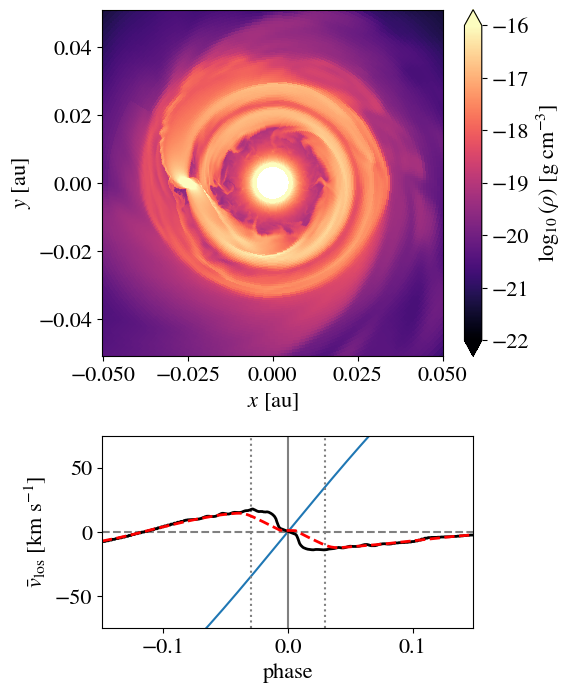

In [7]:
d,sep,b,sigma,vr = read_get_sigmab(base_dir="/Users/morganmacleod/DATA/streams_backup/grida/a0.025/l8r2/",
                             fn="PW.out1.00003.athdf",
                             level=3,
                             x1_min=7e10,
                             x1_min_los=3*7e10,
                             x1_max=0.1*c.au*2,
                             x3range = np.pi, #np.pi/2.5,
                             nanthresh=1e-11)


makefigV(d,sep,b,sigma,vr)
plt.savefig("figures/stream_slice_los.pdf",bbox_inches='tight')

reading orbit file for planet wind simulation...
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.05/l2r0.5/PW.out1.00003.athdf
 ...file read, constructing arrays
 ...gamma= 1.0001
...getting cartesian arrays...


/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/2338882533.py:163: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



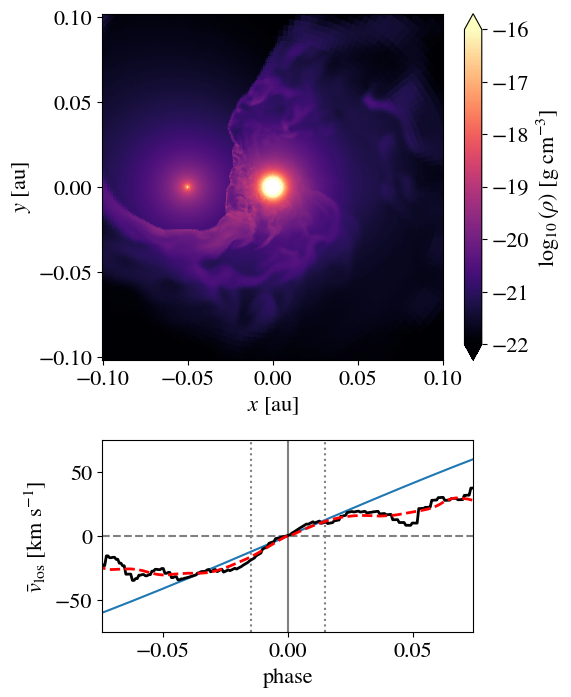

In [8]:
d,sep,b,sigma,vr = read_get_sigmab(base_dir="/Users/morganmacleod/DATA/streams_backup/grida/a0.05/l2r0.5/",
                             fn="PW.out1.00003.athdf",
                             level=3,
                             x1_min=7e10,
                             x1_min_los=3.*7e10,
                             x1_max=0.1*c.au*2,
                             x3range = np.pi, #np.pi/2.5,
                             nanthresh=1e-11)


makefigV(d,sep,b,sigma,vr)
plt.savefig("figures/bubble_slice_los_a05.pdf",bbox_inches='tight')

# Lambda progression

reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l2r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125238.82
0.6495856819702487
rB/rp= 6.215245753856264 rB/a= 0.11601792073865026
0 1.5697958


/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/3595903924.py:108: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/3595903924.py:121: UserWarning:

The following kwargs were not used by contour: 'rasterized'

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/3595903924.py:140: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/3595903924.py:152: UserWarning:

The following kwargs were not used by contour: 'rasterized'

/var/folders/4

reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l4r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125234.0
0.6495606800900424
rB/rp= 4.394842419292661 rB/a= 0.082037058493463
0 1.5697958
reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l8r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125235.19
0.6495668393863007
rB/rp= 3

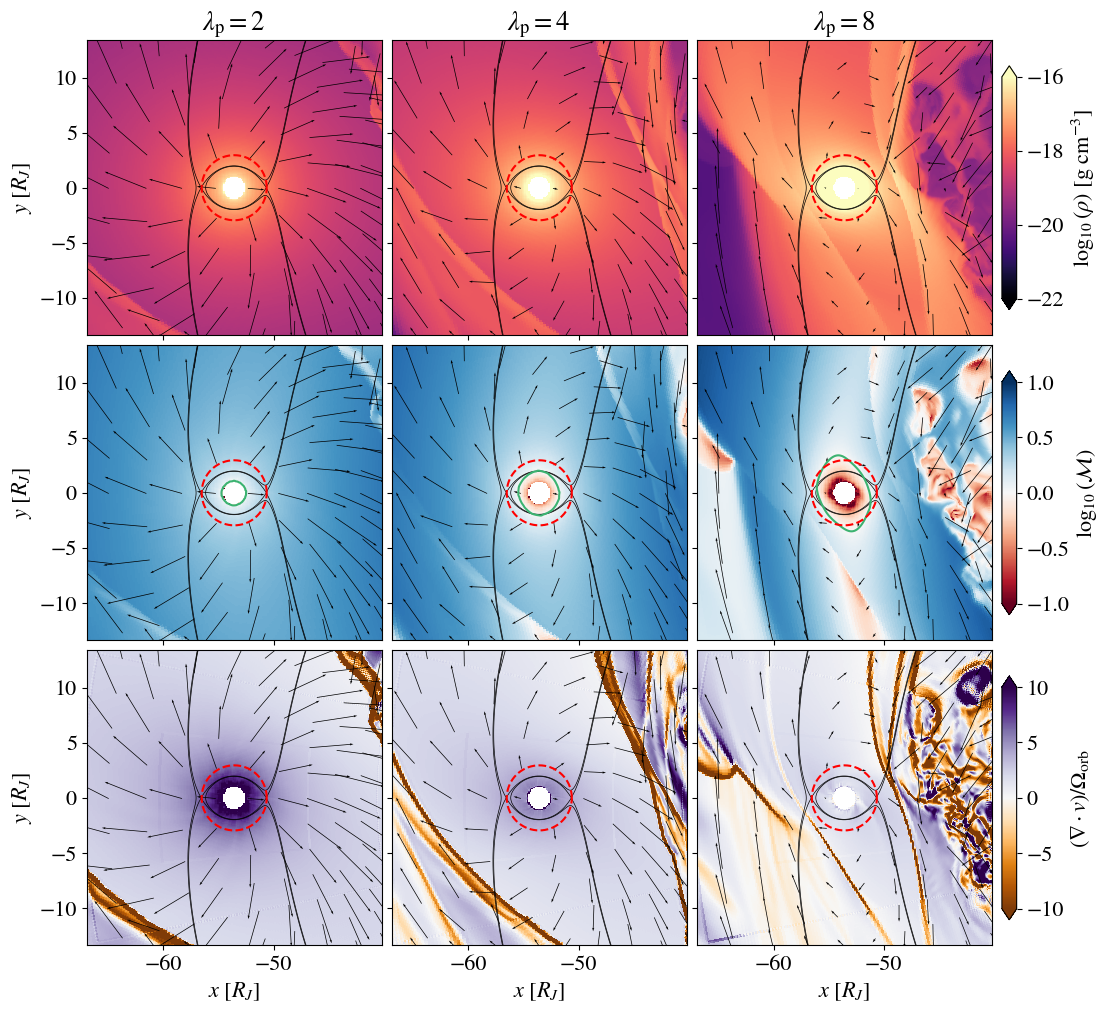

In [10]:
def get_phiL12(d,orb):
    x3ray = np.argmin(np.abs(d['x3v']-np.pi) )
    phi1 = d['PhiEff'][x3ray,0, np.argmax(d['PhiEff'][x3ray,0,d['x1v']<orb['sep'][0]] )]
    phi2 = d['PhiEff'][x3ray,0, np.argmax(d['PhiEff'][x3ray,0,:] )]
    return phi1,phi2

def divV_midplane(d):
    divV = ( d['gx1v']**(-2) *  np.gradient(d['gx1v']**2 * d['vel1'],axis=2,edge_order=2)/np.gradient(d['gx1v'],axis=2,edge_order=2) +
         #1/(d['gx1v']*np.sin(d['gx2v'])) *  np.gradient(np.sin(d['gx2v']) *d['vel2'],axis=1)/np.gradient(d['gx2v'],axis=1) +
         1/(d['gx1v']*np.sin(d['gx2v'])) *  np.gradient(d['vel3'],axis=0,edge_order=2)/np.gradient(d['gx3v'],axis=0,edge_order=2) )
    return divV

def vorticity_midplane(d):
    """phi component of vorticity"""
    vortth = 1/d['gx1v']*(1/np.sin(d['gx2v'])*np.gradient(d['vel1'],axis=0,edge_order=2)/np.gradient(d['gx3v'],axis=0,edge_order=2) - np.gradient(d['gx1v']*d['vel3'],axis=2,edge_order=2)/np.gradient(d['gx1v'],axis=2,edge_order=2) )
    vortz = - np.sin(d['gx2v'])*vortth
    return vortz

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12,15))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(3, 3),  
                 axes_pad=0.1,
                 cbar_location='right',
                 cbar_mode='edge')

dirlist = ["/Users/morganmacleod/DATA/streams_backup/grida/a0.025/l2r1/",
           "/Users/morganmacleod/DATA/streams_backup/grida/a0.025/l4r1/",
           "/Users/morganmacleod/DATA/streams_backup/grida/a0.025/l8r1/"]
titles = [r'$\lambda_{\rm p} = 2$',
          r'$\lambda_{\rm p} = 4$',
          r'$\lambda_{\rm p} = 8$']
lam = [2,4,8]

xyscale = 7e9

for i,base_dir in enumerate(dirlist):

    orb = pw.read_trackfile(base_dir+"pm_trackfile.dat")
    print( "ORB: ... ", orb.colnames)

    myfile = base_dir+"PW.out1.00001.athdf"
    mylevel = 4
    x2sliceval = pw.get_midplane_theta(myfile,mylevel)

    # NOTE: read @level=None to get full resolution. 
    #  Helps to add slice in that case or will be too big for memory
    d = pw.read_data(myfile,orb,
                     level=mylevel,
                     get_cartesian=True,
                     x1_max = 0.1*c.au*2,
                     x2_min = x2sliceval, x2_max = x2sliceval,
                     #x3_min = 3*np.pi/4, x3_max = 5*np.pi/4
                    )

    t= d['Time']
    rcom,vcom = pw.rcom_vcom(orb,t)
    x2,y2,z2 = pw.pos_secondary(orb,t)
    print( t)
    print(t/192798)

    Omega = np.sqrt(c.G*(orb['m1'][0]+orb['m2'][0])/orb['sep'][0]**3)
    d['d2'] = np.sqrt((d['x']-x2)**2 + (d['y']-y2)**2 +(d['z']-z2)**2 )
    d['vel3inertial'] = d['vel3'] + Omega*d['gx1v']*np.sin(d['gx2v'])
    d['EK']   = 0.5*(d['vel1']**2 + d['vel2']**2 + d['vel3inertial']**2)
    d['EPot'] = - c.G * orb['m1'][0] / d['gx1v'] - c.G * orb['m2'][0]/d['d2']
    d['EI']   = d['press']/((1.0001-1)*d['rho'])
    d['Etot'] = d['EK'] + d['EI'] + d['EPot']
    d['Bern'] = d['Etot'] + d['press']/d['rho']
    d['PhiEff'] = d['EPot'] - 0.5*(Omega*d['gx1v']*np.sin(d['gx2v']))**2
    d['EJ'] = 0.5*(d['vel1']**2 + d['vel2']**2 + d['vel3']**2) + d['PhiEff']
    d['l'] = d['gx1v']*np.sin(d['gx2v'])*d['vel3inertial']
    d['vrp'] = (d['vx']*(d['x']-x2) + d['vy']*(d['y']-y2) + d['vz']*(d['z']-z2))/d['d2']
    d['vxp'] = (d['vx']*(d['y']-y2) - d['vy']*(d['x']-x2))/ np.sqrt((d['x']-x2)**2 + (d['y']-y2)**2)
    d['divV'] = divV_midplane(d)
    d['vort'] = vorticity_midplane(d)
    d['cs'] = np.sqrt(d['press']/d['rho'])
    d['mach'] = np.sqrt(d['vel1']**2 + d['vel2']**2 + d['vel3']**2)/d['cs']

    # parse filename to get rp
    rp = int(base_dir[-2:-1])
    rp=np.where(rp==5,0.5,rp)
    rp*=7e9
    
    # sound speed
    cs = np.sqrt(c.G*1e30/rp/lam[i])
    #rs = rp*lam[i]/2
    rB = (cs/Omega)
    print("rB/rp=",rB/rp,"rB/a=",rB/orb['sep'][0])
    
    
    
    ##### PLOT SETUP
    lim = orb['sep'][0] / xyscale /4
    skip = 24
    r0thresh=0.0
    vscale = 5e7
    sel = (d['r0']>r0thresh) & (d['d2']>rp)
    rH = (orb['m2'][0]/(3*orb['m1'][0]))**(1/3) * orb['sep'][0]

    th_ind = int(d['x'].shape[1]/2)
    #th_ind = 0
    print(th_ind, d['x2v'][th_ind])

    
    #### DENSITY PANEL 
    im=grid[i].pcolormesh(d['x'][:,th_ind,:]/xyscale,
                   d['y'][:,th_ind,:]/xyscale,
                   np.where(sel,np.log10(d['rho']),np.nan)[:,th_ind,:] ,
                   cmap=plt.cm.magma,vmax=-16,vmin=-22,rasterized=True)
    grid[i].cax.colorbar(im,label=r"$\log_{10} \left( \rho  \right)$ [g cm$^{-3}$]",extend='both')


    grid[i].quiver(d['x'][::skip,th_ind,::skip]/xyscale,
               d['y'][::skip,th_ind,::skip]/xyscale,
               np.where(sel,d['vx'],np.nan)[::skip,th_ind,::skip],
               np.where(sel,d['vy'],np.nan)[::skip,th_ind,::skip],scale=vscale,rasterized=True )

    phi1,phi2 = get_phiL12(d,orb)
    grid[i].contour(d['x'][:,th_ind,:]/xyscale,
               d['y'][:,th_ind,:]/xyscale,
               d['PhiEff'][:,th_ind,:],
              levels=[phi1,phi2],colors='k',linestyles='-',linewidths=0.5,rasterized=True )


    tt = np.linspace(0,2*np.pi,361)
    grid[i].plot((rH*np.cos(tt)+x2)/xyscale,(rH*np.sin(tt))/xyscale,'r--',zorder=10,rasterized=True)

    #grid[i].plot(x2,y2,'w+')

    grid[i].set_xlim(-lim+x2/xyscale,lim+x2/xyscale)
    grid[i].set_ylim(-lim,lim)
    grid[i].set_xlabel(r'$x \ [R_J]$')
    grid[i].set_ylabel(r'$y \ [R_J]$')
    grid[i].set_title(titles[i])
    
    
    #### SHOCKS PANEL
    im=grid[i+6].pcolormesh(d['x'][:,th_ind,:]/xyscale,
                   d['y'][:,th_ind,:]/xyscale,
                   np.where(sel,d['divV'],np.nan)[:,th_ind,:]/Omega,
                   cmap=plt.cm.PuOr,vmin=-10,vmax=10,rasterized=True)
    grid[i+6].cax.colorbar(im,label=r"$(\nabla \cdot v) / \Omega_{\rm orb}$",extend='both')


    grid[i+6].quiver(d['x'][::skip,th_ind,::skip]/xyscale,
               d['y'][::skip,th_ind,::skip]/xyscale,
               np.where(sel,d['vx'],np.nan)[::skip,th_ind,::skip],
               np.where(sel,d['vy'],np.nan)[::skip,th_ind,::skip],scale=vscale,rasterized=True )

    grid[i+6].contour(d['x'][:,th_ind,:]/xyscale,
               d['y'][:,th_ind,:]/xyscale,
               d['PhiEff'][:,th_ind,:],
              levels=[phi1,phi2],colors='k',linestyles='-',linewidths=0.5,rasterized=True )


    grid[i+6].plot((rH*np.cos(tt)+x2)/xyscale,rH*np.sin(tt)/xyscale,'r--',zorder=10,rasterized=True)
    #grid[i+6].plot((rB*np.cos(tt)+x2)/xyscale,rB*np.sin(tt)/xyscale,'C1--',zorder=10)

    grid[i+6].set_xlim(-lim+x2/xyscale,lim+x2/xyscale)
    grid[i+6].set_ylim(-lim,lim)
    grid[i+6].set_xlabel(r'$x \ [R_J]$')
    grid[i+6].set_ylabel(r'$y \ [R_J]$')
    
    
    #### MACH PANEL
    im=grid[i+3].pcolormesh(d['x'][:,th_ind,:]/xyscale,
                   d['y'][:,th_ind,:]/xyscale,
                   np.log10(np.where(sel,d['mach'],np.nan))[:,th_ind,:],
                   cmap=plt.cm.RdBu,vmin=-1,vmax=1,rasterized=True)
    grid[i+3].cax.colorbar(im,label=r"$\log_{10} ( \cal M)$",extend='both')
    grid[i+3].set_xlim(-lim+x2/xyscale,lim+x2/xyscale)
    grid[i+3].set_ylim(-lim,lim)
    
    grid[i+3].set_xlim(-lim+x2/xyscale,lim+x2/xyscale)
    grid[i+3].set_ylim(-lim,lim)
    grid[i+3].set_xlabel(r'$x \ [R_J]$')
    grid[i+3].set_ylabel(r'$y \ [R_J]$')
    
    grid[i+3].quiver(d['x'][::skip,th_ind,::skip]/xyscale,
               d['y'][::skip,th_ind,::skip]/xyscale,
               np.where(sel,d['vx'],np.nan)[::skip,th_ind,::skip],
               np.where(sel,d['vy'],np.nan)[::skip,th_ind,::skip],scale=vscale ,rasterized=True)

    grid[i+3].contour(d['x'][:,th_ind,:]/xyscale,
               d['y'][:,th_ind,:]/xyscale,
               d['PhiEff'][:,th_ind,:],
              levels=[phi1,phi2],colors='k',linestyles='-',linewidths=0.5 ,rasterized=True)
    grid[i+3].contour(d['x'][:,th_ind,:]/xyscale,
               d['y'][:,th_ind,:]/xyscale,
               np.log10(np.where((d['r0']>r0thresh) & (d['d2']<4*7e9),d['mach'],np.nan))[:,th_ind,:],
                levels=[0],colors='mediumseagreen',rasterized=True)

    grid[i+3].plot((rH*np.cos(tt)+x2)/xyscale,(rH*np.sin(tt))/xyscale,'r--',zorder=10,rasterized=True)


plt.savefig("figures/lp_progression_all3.pdf",bbox_inches='tight',dpi=150)

# Phase Space

reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l2r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125238.82
0.6495856819702487
reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l4r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125234.0
0.6495606800900424
reading orbit file for planet wind simulation...
ORB: ...  ['ncycle',

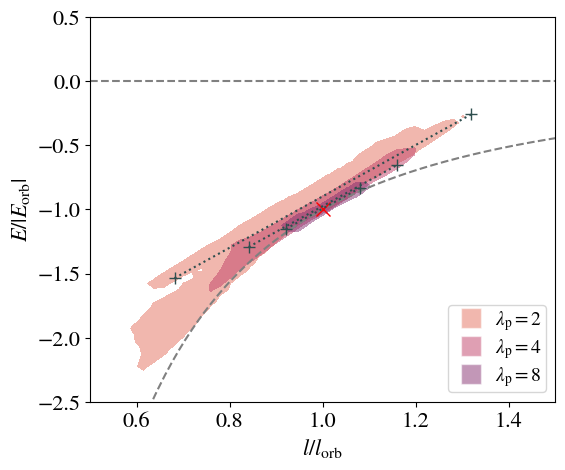

In [19]:
#dirlist = ["/Volumes/LaCie/streams/grida/a0.025/l2r1/",
#           "/Volumes/LaCie/streams/grida/a0.025/l4r1/",
#           "/Volumes/LaCie/streams/grida/a0.025/l8r1/"]
titles = [r'$\lambda_{\rm p} = 2$',
          r'$\lambda_{\rm p} = 4$',
          r'$\lambda_{\rm p} = 8$']
lam = [2,4,8]

xyscale = 7e9

mycm = sns.color_palette('flare',n_colors=3)

for i,base_dir in enumerate(dirlist):

    orb = pw.read_trackfile(base_dir+"pm_trackfile.dat")
    print( "ORB: ... ", orb.colnames)

    omega_orb = np.sqrt(c.G*orb['m1'][0]/orb['sep'][0]**3)

    myfile = base_dir+"PW.out1.00001.athdf"
    mylevel = 1
    x2sliceval = pw.get_midplane_theta(myfile,mylevel)

    # NOTE: read @level=None to get full resolution. 
    #  Helps to add slice in that case or will be too big for memory
    d = pw.read_data(myfile,orb,
                     level=mylevel,
                     get_cartesian=True,
                     x1_max = 0.1*c.au,
                     #x2_min = x2sliceval, x2_max = x2sliceval,
                     #x3_min = 3*np.pi/4, x3_max = 5*np.pi/4
                    )

    t= d['Time']
    rcom,vcom = pw.rcom_vcom(orb,t)
    x2,y2,z2 = pw.pos_secondary(orb,t)
    print( t)
    print(t/192798)

    Omega = np.sqrt(c.G*(orb['m1'][0]+orb['m2'][0])/orb['sep'][0]**3)
    d['d2'] = np.sqrt((d['x']-x2)**2 + (d['y']-y2)**2 +(d['z']-z2)**2 )
    d['vel3inertial'] = d['vel3'] + Omega*d['gx1v']*np.sin(d['gx2v'])
    d['EK']   = 0.5*(d['vel1']**2 + d['vel2']**2 + d['vel3inertial']**2)
    d['EPot'] = - c.G * orb['m1'][0] / d['gx1v'] - c.G * orb['m2'][0]/d['d2']
    d['EI']   = d['press']/((1.0001-1)*d['rho'])
    d['Etot'] = d['EK'] + d['EI'] + d['EPot']
    d['Bern'] = d['Etot'] + d['press']/d['rho']
    d['PhiEff'] = d['EPot'] - 0.5*(Omega*d['gx1v']*np.sin(d['gx2v']))**2
    d['EJ'] = 0.5*(d['vel1']**2 + d['vel2']**2 + d['vel3']**2) + d['PhiEff']
    d['l'] = d['gx1v']*np.sin(d['gx2v'])*d['vel3inertial']
    d['vrp'] = (d['vx']*(d['x']-x2) + d['vy']*(d['y']-y2) + d['vz']*(d['z']-z2))/d['d2']
    d['vxp'] = (d['vx']*(d['y']-y2) - d['vy']*(d['x']-x2))/ np.sqrt((d['x']-x2)**2 + (d['y']-y2)**2)
    d['divV'] = divV_midplane(d)
    d['vort'] = vorticity_midplane(d)
    d['cs'] = np.sqrt(d['press']/d['rho'])
    d['mach'] = np.sqrt(d['vel1']**2 + d['vel2']**2 + d['vel3']**2)/d['cs']

    # parse filename to get rp
    rp = int(base_dir[-2:-1])
    rp=np.where(rp==5,0.5,rp)
    rp*=7e9


    vorb = np.sqrt(c.G*(orb['m1'][0]+orb['m2'][0])/orb['sep'][0])
    lorb = orb['sep'][0]*vorb
    Eorb = 0.5*vorb**2 

    sel = (d['r0']>0.3)
    h,xe,ye = np.histogram2d(d['l'][sel]/lorb,(d['EK']+d['EPot'])[sel]/Eorb,bins=60,range=[[0.25,1.5],[-2.5,0.5]])
    x = 0.5*(xe[1:]+xe[0:-1])
    y = 0.5*(ye[1:]+ye[0:-1])
    plt.contourf(x,y,h.T,levels=[np.max(h)/10,np.max(h)],colors=[mycm[i]],alpha=0.5)


plt.ylabel(r'$E/|E_{\rm orb}|$')
plt.xlabel(r'$l/l_{\rm orb}$')

xp = np.linspace(0.1,10,1000)*orb['sep'][0]
El = -0.5*c.G*(orb['m1'][0]+orb['m2'][0])/xp
ll = np.sqrt(c.G*(orb['m1'][0]+orb['m2'][0])*xp)
plt.plot(ll/lorb,El/Eorb,'--',color='grey')
plt.axhline(0,ls='--',color='grey')

plt.plot(1,-1,'rx',markersize=10,lw=2)
plt.ylim(-2.5,0.5)
plt.xlim(0.5,1.5)

for i in range(3):
    plt.plot(10,10,marker='s',ls='',markersize=15,markeredgecolor='w',color=mycm[i],alpha=0.5,label=titles[i])
plt.legend(loc='lower right',frameon=True)


for i,vw in enumerate([15e5,30e5,60e5]):
    lp = (vorb + vw)* orb['sep'][0]
    lm = (vorb - vw)* orb['sep'][0]
    Ep = -c.G*orb['m1'][0]/orb['sep'][0]  + 0.5*(vorb + vw)**2 #- c.G*Mp/Rp
    Em = -c.G*orb['m1'][0]/orb['sep'][0]  + 0.5*(vorb - vw)**2 #- c.G*Mp/Rp

    plt.plot([lm/lorb,lp/lorb] ,[Em/Eorb, Ep/Eorb],'+:',markersize=8, color='darkslategrey')

plt.savefig("figures/lp_progression_EJ_phase.pdf",bbox_inches='tight')

reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l2r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125238.82
0.6495856819702487
0 1.5667086
reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l4r1/PW.out1.00001.athdf


/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/1019478438.py:92: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125234.0
0.6495606800900424
0 1.5667086
reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l8r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125235.19
0.6495668393863007
0 1.5667086


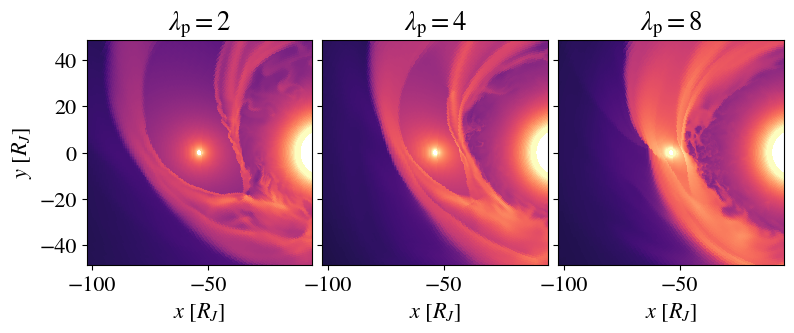

In [20]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(9,7))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 3),  
                 axes_pad=0.1,
                 cbar_location='right',
                 cbar_mode=None)

#dirlist = ["/Volumes/LaCie/streams/grida/a0.025/l2r1/",
#           "/Volumes/LaCie/streams/grida/a0.025/l4r1/",
#           "/Volumes/LaCie/streams/grida/a0.025/l8r1/"]
titles = [r'$\lambda_{\rm p} = 2$',
          r'$\lambda_{\rm p} = 4$',
          r'$\lambda_{\rm p} = 8$']
lam = [2,4,8]

xyscale = 7e9

for i,base_dir in enumerate(dirlist):

    orb = pw.read_trackfile(base_dir+"pm_trackfile.dat")
    print( "ORB: ... ", orb.colnames)

    omega_orb = np.sqrt(c.G*orb['m1'][0]/orb['sep'][0]**3)

    myfile = base_dir+"PW.out1.00001.athdf"
    mylevel = 2
    x2sliceval = pw.get_midplane_theta(myfile,mylevel)

    # NOTE: read @level=None to get full resolution. 
    #  Helps to add slice in that case or will be too big for memory
    d = pw.read_data(myfile,orb,
                     level=mylevel,
                     get_cartesian=True,
                     x1_max = 0.1*c.au*2,
                     x2_min = x2sliceval, x2_max = x2sliceval,
                     #x3_min = 3*np.pi/4, x3_max = 5*np.pi/4
                    )

    t= d['Time']
    rcom,vcom = pw.rcom_vcom(orb,t)
    x2,y2,z2 = pw.pos_secondary(orb,t)
    print( t)
    print(t/192798)

    Omega = np.sqrt(c.G*(orb['m1'][0]+orb['m2'][0])/orb['sep'][0]**3)
    d['d2'] = np.sqrt((d['x']-x2)**2 + (d['y']-y2)**2 +(d['z']-z2)**2 )
    d['vel3inertial'] = d['vel3'] + Omega*d['gx1v']*np.sin(d['gx2v'])
    d['EK']   = 0.5*(d['vel1']**2 + d['vel2']**2 + d['vel3inertial']**2)
    d['EPot'] = - c.G * orb['m1'][0] / d['gx1v'] - c.G * orb['m2'][0]/d['d2']
    d['EI']   = d['press']/((1.0001-1)*d['rho'])
    d['Etot'] = d['EK'] + d['EI'] + d['EPot']
    d['Bern'] = d['Etot'] + d['press']/d['rho']
    d['PhiEff'] = d['EPot'] - 0.5*(Omega*d['gx1v']*np.sin(d['gx2v']))**2
    d['EJ'] = 0.5*(d['vel1']**2 + d['vel2']**2 + d['vel3']**2) + d['PhiEff']
    d['l'] = d['gx1v']*np.sin(d['gx2v'])*d['vel3inertial']
    d['vrp'] = (d['vx']*(d['x']-x2) + d['vy']*(d['y']-y2) + d['vz']*(d['z']-z2))/d['d2']
    d['vxp'] = (d['vx']*(d['y']-y2) - d['vy']*(d['x']-x2))/ np.sqrt((d['x']-x2)**2 + (d['y']-y2)**2)
    d['divV'] = divV_midplane(d)
    d['vort'] = vorticity_midplane(d)
    d['cs'] = np.sqrt(d['press']/d['rho'])
    d['mach'] = np.sqrt(d['vel1']**2 + d['vel2']**2 + d['vel3']**2)/d['cs']

    # parse filename to get rp
    rp = int(base_dir[-2:-1])
    rp=np.where(rp==5,0.5,rp)
    rp*=7e9
    
    # sound speed
    #cs = np.sqrt(c.G*1e30/rp/lam[i])
    #rs = rp*lam[i]/2
    #rB = (cs/Omega)**2/rs
    #print(rB/rp)
    
    
    
    ##### PLOT SETUP
    lim = orb['sep'][0] / xyscale / 1.1
    skip = 24
    r0thresh=0.0
    vscale = 5e7
    sel = (d['r0']>r0thresh) & (d['d2']>rp)
    rH = (orb['m2'][0]/(3*orb['m1'][0]))**(1/3) * orb['sep'][0]

    th_ind = int(d['x'].shape[1]/2)
    #th_ind = 0
    print(th_ind, d['x2v'][th_ind])

    
    #### DENSITY PANEL 
    im=grid[i].pcolormesh(d['x'][:,th_ind,:]/xyscale,
                   d['y'][:,th_ind,:]/xyscale,
                   np.where(sel,np.log10(d['rho']),np.nan)[:,th_ind,:] ,
                   cmap=plt.cm.magma,vmax=-16,vmin=-22,rasterized=True)
    #grid[i].cax.colorbar(im,label=r"$\log_{10} \left( \rho  \right)$",extend='both')

    """
    grid[i].quiver(d['x'][::skip,th_ind,::skip]/xyscale,
               d['y'][::skip,th_ind,::skip]/xyscale,
               np.where(sel,d['vx'],np.nan)[::skip,th_ind,::skip],
               np.where(sel,d['vy'],np.nan)[::skip,th_ind,::skip],scale=vscale,rasterized=True )

    phi1,phi2 = get_phiL12(d,orb)
    grid[i].contour(d['x'][:,th_ind,:]/xyscale,
               d['y'][:,th_ind,:]/xyscale,
               d['PhiEff'][:,th_ind,:],
              levels=[phi1,phi2],colors='k',linestyles='-',linewidths=0.5,rasterized=True )


    tt = np.linspace(0,2*np.pi,361)
    grid[i].plot((rH*np.cos(tt)+x2)/xyscale,(rH*np.sin(tt))/xyscale,'r--',zorder=10,rasterized=True)
    """
    
    #grid[i].plot(x2,y2,'w+')

    grid[i].set_xlim(-lim+x2/xyscale,lim+x2/xyscale)
    grid[i].set_ylim(-lim,lim)
    grid[i].set_xlabel(r'$x \ [R_J]$')
    grid[i].set_ylabel(r'$y \ [R_J]$')
    grid[i].set_title(titles[i])
    
plt.savefig("figures/lp_progression_zodens.pdf",bbox_inches='tight',dpi=150)

reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l2r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125238.82
0.6495856819702487
0 1.568758


/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/640796686.py:86: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/640796686.py:119: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/640796686.py:133: UserWarning:

The following kwargs were not used by contour: 'rasterized'

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_8252/640796686.py:152: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not

reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l4r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125234.0
0.6495606800900424
0 1.568758
reading orbit file for planet wind simulation...
ORB: ...  ['ncycle', 'time', 'dt', 'm1', 'm2', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'sep', 'r', 'rhat', 'v', 'vmag', 'vhat', 'xcom', 'ycom', 'zcom', 'vxcom', 'vycom', 'vzcom', 'rcom', 'vcom']
read_data...reading file /Users/morganmacleod/DATA/streams_backup/grida/a0.025/l8r1/PW.out1.00001.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
125235.19
0.6495668393863007
0 1.568758


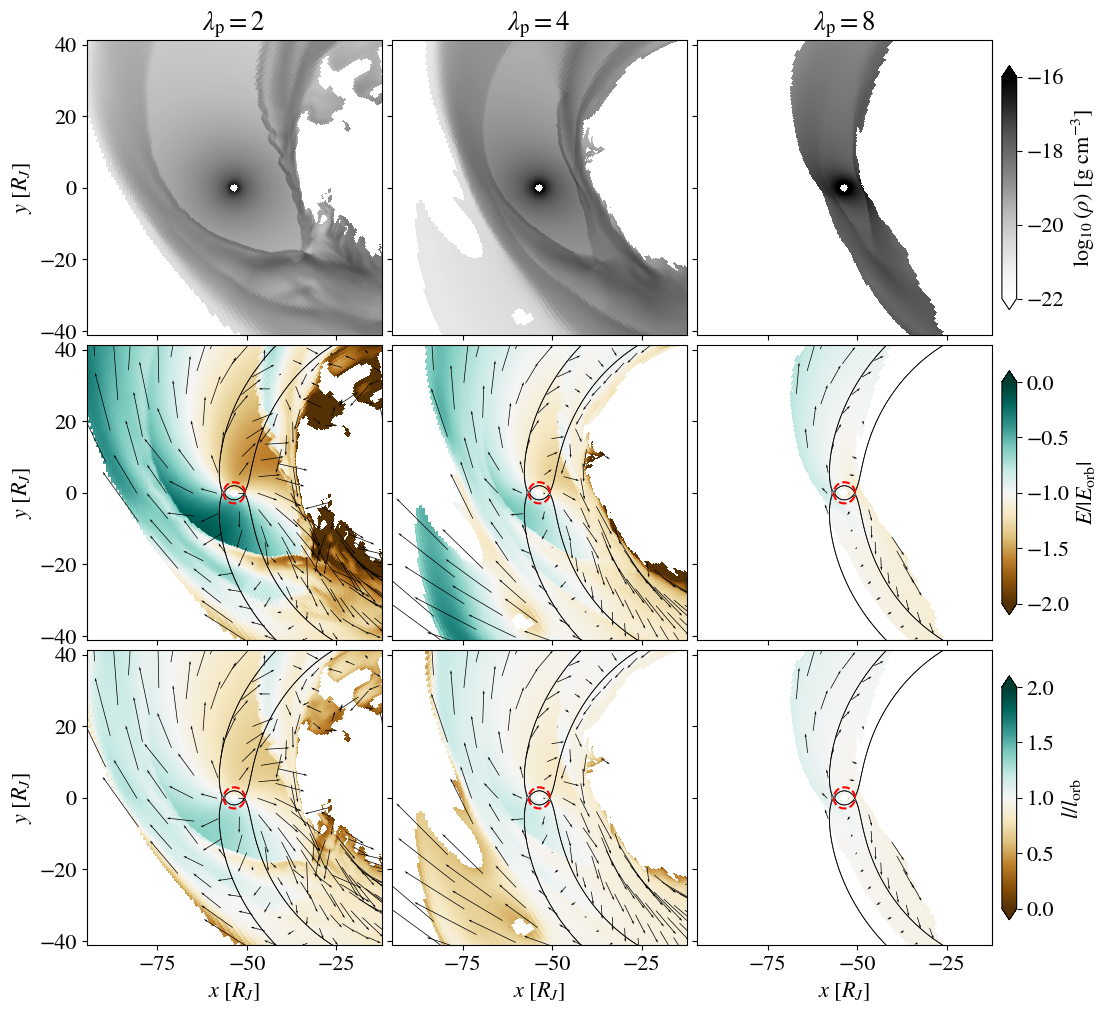

In [21]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12,12))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(3, 3),  
                 axes_pad=0.1,
                 cbar_location='right',
                 cbar_mode='edge')

#dirlist = ["/Volumes/LaCie/streams/grida/a0.025/l2r1/",
#           "/Volumes/LaCie/streams/grida/a0.025/l4r1/",
#           "/Volumes/LaCie/streams/grida/a0.025/l8r1/"]
titles = [r'$\lambda_{\rm p} = 2$',
          r'$\lambda_{\rm p} = 4$',
          r'$\lambda_{\rm p} = 8$']
lam = [2,4,8]

xyscale = 7e9

for i,base_dir in enumerate(dirlist):

    orb = pw.read_trackfile(base_dir+"pm_trackfile.dat")
    print( "ORB: ... ", orb.colnames)

    omega_orb = np.sqrt(c.G*orb['m1'][0]/orb['sep'][0]**3)

    myfile = base_dir+"PW.out1.00001.athdf"
    mylevel = 3
    x2sliceval = pw.get_midplane_theta(myfile,mylevel)

    # NOTE: read @level=None to get full resolution. 
    #  Helps to add slice in that case or will be too big for memory
    d = pw.read_data(myfile,orb,
                     level=mylevel,
                     get_cartesian=True,
                     x1_max = 0.1*c.au*2,
                     x2_min = x2sliceval, x2_max = x2sliceval,
                     #x3_min = 3*np.pi/4, x3_max = 5*np.pi/4
                    )

    t= d['Time']
    rcom,vcom = pw.rcom_vcom(orb,t)
    x2,y2,z2 = pw.pos_secondary(orb,t)
    print( t)
    print(t/192798)

    Omega = np.sqrt(c.G*(orb['m1'][0]+orb['m2'][0])/orb['sep'][0]**3)
    d['d2'] = np.sqrt((d['x']-x2)**2 + (d['y']-y2)**2 +(d['z']-z2)**2 )
    d['vel3inertial'] = d['vel3'] + Omega*d['gx1v']*np.sin(d['gx2v'])
    d['EK']   = 0.5*(d['vel1']**2 + d['vel2']**2 + d['vel3inertial']**2)
    d['EPot'] = - c.G * orb['m1'][0] / d['gx1v'] - c.G * orb['m2'][0]/d['d2']
    d['EI']   = d['press']/((1.0001-1)*d['rho'])
    d['Etot'] = d['EK'] + d['EI'] + d['EPot']
    d['Bern'] = d['Etot'] + d['press']/d['rho']
    d['PhiEff'] = d['EPot'] - 0.5*(Omega*d['gx1v']*np.sin(d['gx2v']))**2
    d['EJ'] = 0.5*(d['vel1']**2 + d['vel2']**2 + d['vel3']**2) + d['PhiEff']
    d['l'] = d['gx1v']*np.sin(d['gx2v'])*d['vel3inertial']
    d['vrp'] = (d['vx']*(d['x']-x2) + d['vy']*(d['y']-y2) + d['vz']*(d['z']-z2))/d['d2']
    d['vxp'] = (d['vx']*(d['y']-y2) - d['vy']*(d['x']-x2))/ np.sqrt((d['x']-x2)**2 + (d['y']-y2)**2)
    d['divV'] = divV_midplane(d)
    d['vort'] = vorticity_midplane(d)
    d['cs'] = np.sqrt(d['press']/d['rho'])
    d['mach'] = np.sqrt(d['vel1']**2 + d['vel2']**2 + d['vel3']**2)/d['cs']

    # parse filename to get rp
    rp = int(base_dir[-2:-1])
    rp=np.where(rp==5,0.5,rp)
    rp*=7e9
    
    
    
    
    ##### PLOT SETUP
    lim = orb['sep'][0] / xyscale /1.3
    skip = 24
    r0thresh=0.3
    vscale = 1e8
    sel = (d['r0']>r0thresh) & (d['d2']>rp)
    rH = (orb['m2'][0]/(3*orb['m1'][0]))**(1/3) * orb['sep'][0]

    th_ind = int(d['x'].shape[1]/2)
    #th_ind = 0
    print(th_ind, d['x2v'][th_ind])
    
        #### DENSITY PANEL 
    im=grid[i].pcolormesh(d['x'][:,th_ind,:]/xyscale,
                   d['y'][:,th_ind,:]/xyscale,
                   np.where(sel,np.log10(d['rho']),np.nan)[:,th_ind,:] ,
                   cmap=plt.cm.Greys,vmax=-16,vmin=-22,rasterized=True)
    grid[i].cax.colorbar(im,label=r"$\log_{10} \left( \rho  \right)$ [g cm$^{-3}$]",extend='both')

    """
    grid[i].quiver(d['x'][::skip,th_ind,::skip]/xyscale,
               d['y'][::skip,th_ind,::skip]/xyscale,
               np.where(sel,d['vx'],np.nan)[::skip,th_ind,::skip],
               np.where(sel,d['vy'],np.nan)[::skip,th_ind,::skip],scale=vscale,rasterized=True )

    phi1,phi2 = get_phiL12(d,orb)
    grid[i].contour(d['x'][:,th_ind,:]/xyscale,
               d['y'][:,th_ind,:]/xyscale,
               d['PhiEff'][:,th_ind,:],
              levels=[phi1,phi2],colors='k',linestyles='-',linewidths=0.5,rasterized=True )


    tt = np.linspace(0,2*np.pi,361)
    grid[i].plot((rH*np.cos(tt)+x2)/xyscale,(rH*np.sin(tt))/xyscale,'r--',zorder=10,rasterized=True)
    """
    
    #grid[i].plot(x2,y2,'w+')

    grid[i].set_xlim(-lim+x2/xyscale,lim+x2/xyscale)
    grid[i].set_ylim(-lim,lim)
    grid[i].set_xlabel(r'$x \ [R_J]$')
    grid[i].set_ylabel(r'$y \ [R_J]$')
    grid[i].set_title(titles[i])

    
    #### E PANEL 
    im=grid[i+3].pcolormesh(d['x'][:,th_ind,:]/xyscale,
                   d['y'][:,th_ind,:]/xyscale,
                   np.where(sel,d['EK']+d['EPot'],np.nan)[:,th_ind,:]/Eorb ,
                   cmap=plt.cm.BrBG,vmin=-2,vmax=0,rasterized=True)
    grid[i+3].cax.colorbar(im,label=r"$E / |E_{\rm orb}|$",extend='both')



    grid[i+3].quiver(d['x'][::skip,th_ind,::skip]/xyscale,
               d['y'][::skip,th_ind,::skip]/xyscale,
               np.where(sel,d['vx'],np.nan)[::skip,th_ind,::skip],
               np.where(sel,d['vy'],np.nan)[::skip,th_ind,::skip],scale=vscale,rasterized=True )

    phi1,phi2 = get_phiL12(d,orb)
    grid[i+3].contour(d['x'][:,th_ind,:]/xyscale,
               d['y'][:,th_ind,:]/xyscale,
               d['PhiEff'][:,th_ind,:],
              levels=[phi1,phi2],colors='k',linestyles='-',linewidths=0.5,rasterized=True )


    tt = np.linspace(0,2*np.pi,361)
    grid[i+3].plot((rH*np.cos(tt)+x2)/xyscale,(rH*np.sin(tt))/xyscale,'r--',zorder=10,rasterized=True)

    #grid[i].plot(x2,y2,'w+')

    grid[i+3].set_xlim(-lim+x2/xyscale,lim+x2/xyscale)
    grid[i+3].set_ylim(-lim,lim)
    grid[i+3].set_xlabel(r'$x \ [R_J]$')
    grid[i+3].set_ylabel(r'$y \ [R_J]$')
    #grid[i+3].set_title(titles[i])
    
    
    #### J PANEL
    im=grid[i+6].pcolormesh(d['x'][:,th_ind,:]/xyscale,
                   d['y'][:,th_ind,:]/xyscale,
                   np.where(sel,d['l'],np.nan)[:,th_ind,:]/lorb ,
                   cmap=plt.cm.BrBG,vmin=0,vmax=2,rasterized=True)
    grid[i+6].cax.colorbar(im,label=r"$l/l_{\rm orb}$",extend='both')


    grid[i+6].quiver(d['x'][::skip,th_ind,::skip]/xyscale,
               d['y'][::skip,th_ind,::skip]/xyscale,
               np.where(sel,d['vx'],np.nan)[::skip,th_ind,::skip],
               np.where(sel,d['vy'],np.nan)[::skip,th_ind,::skip],scale=vscale,rasterized=True )

    grid[i+6].contour(d['x'][:,th_ind,:]/xyscale,
               d['y'][:,th_ind,:]/xyscale,
               d['PhiEff'][:,th_ind,:],
              levels=[phi1,phi2],colors='k',linestyles='-',linewidths=0.5,rasterized=True )


    tt = np.linspace(0,2*np.pi,361)
    grid[i+6].plot((rH*np.cos(tt)+x2)/xyscale,rH*np.sin(tt)/xyscale,'r--',zorder=10,rasterized=True)
    #grid[i+3].plot((rB*np.cos(tt)+x2)/xyscale,rB*np.sin(tt)/xyscale,'C1--',zorder=10)

    grid[i+6].set_xlim(-lim+x2/xyscale,lim+x2/xyscale)
    grid[i+6].set_ylim(-lim,lim)
    grid[i+6].set_xlabel(r'$x \ [R_J]$')
    grid[i+6].set_ylabel(r'$y \ [R_J]$')
    


plt.savefig("figures/lp_progression_EJ.pdf",bbox_inches='tight',dpi=150)

# Table

In [22]:
# Save velocities, and vkep: v_ingress, v_egress, vp_ingress, vp_egress

filelist = glob("morphology_data/1d_wa*1.ecsv")
filelist

vtable = []
for fn in filelist:
    bd = ascii.read(fn)
    db = bd['b'][1]-bd['b'][0]
    width = 2*c.rsun/db
    bd['vrc'] = convolve(bd['vr'],Box1DKernel(width) ,nan_treatment='fill',fill_value=np.nan)
    v_ingress = np.interp(7e10,bd['b'],bd['vrc'])/1e5
    v_egress  = np.interp(-7e10,bd['b'],bd['vrc'])/1e5
    sep = bd.meta['sep']*c.au
    vp_ingress = np.sin(-7e10/sep) * np.sqrt( c.G*c.msun/sep )/1e5
    vp_egress = np.sin(7e10/sep) * np.sqrt( c.G*c.msun/sep )/1e5
    vtable.append([bd.meta['lambda'],bd.meta['rp'],bd.meta['sep'],bd.meta['wind'],v_ingress,v_egress,vp_ingress,vp_egress])
    

vtable = Table(np.array(vtable),
               names=["lambda",'rp','sep','wind',"v_ingress","v_egress","vp_ingress","vp_egress"],
               dtype=[float,float,float,str,float,float,float,float])

vtable['Omega'] = np.sqrt(c.G*c.msun/(vtable['sep']*c.au)**3)
vtable['rs'] = vtable['rp']*7.149e9*vtable['lambda']/2
vtable['rH'] = (1.e30/(3*c.msun))**(1/3.) * vtable['sep']*c.au
vtable['vH'] = np.sqrt(c.G * 1e30/ vtable['rH'])/1.e5 #km/s 
vtable['vshearOmrH'] = vtable['Omega']*vtable['rH'] /1.e5 #km/s
vtable['cs'] = np.sqrt(c.G*1.e30/(7.149e9*vtable['rp']*vtable['lambda']))/1.e5 #km/s
vtable['RoH'] =  vtable['cs']/vtable['vshearOmrH']
vtable['lambda_H'] = 3 / vtable['RoH']**2
vtable['lambda_H_direct'] = c.G*1e30/(vtable['rH'] * (vtable['cs']*1e5)**2 ) 
vtable['gradV'] = (vtable['v_egress']-vtable['v_ingress'])/(vtable['vp_egress']-vtable['vp_ingress']) 


print('table calculated')
###

# as a double check
#print( (vtable['lambda_H']/vtable['lambda_H_direct'])[0:3]  )
#print( (vtable['vH']/(3**0.5 * vtable['vshearOmrH'])  )[0:3] )

table calculated


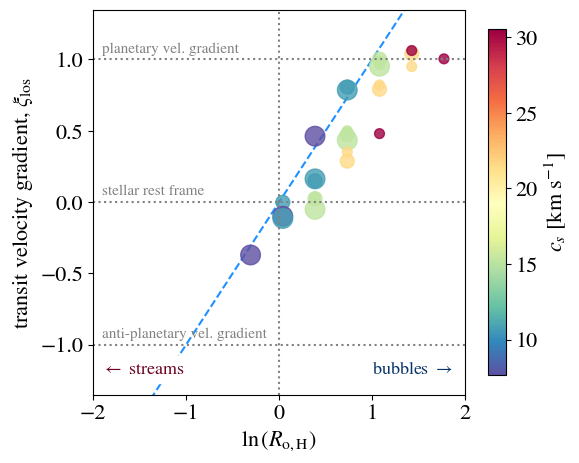

In [23]:
plt.figure(figsize=(6,5))


plt.scatter(np.log(vtable['RoH']),
            vtable['gradV'],
            c=vtable['cs'],
            s=vtable['rp']*100,
            alpha=0.8,cmap='Spectral_r')

cbar=plt.colorbar(label=r'$c_s$ [km s$^{-1}$]',shrink=0.9)
cbar.solids.set_edgecolor("face")
#plt.semilogx()
xp = np.linspace(-2,2,100)
plt.plot(xp,xp,'--',color='DodgerBlue',zorder=0)
plt.axvline(0,color='grey',ls=':')
plt.axhline(0,color='grey',ls=':')
plt.axhline(-1,color='grey',ls=':')
plt.axhline(1,color='grey',ls=':')
plt.xlim(-2,2)
plt.xlabel(r"$\ln \left(R_{\rm o,H}\right)$")
plt.ylabel(r"transit velocity gradient, $\xi_{\rm los}$")


plt.annotate("planetary vel. gradient",(-1.9,1.05),color='grey',fontsize=11)
plt.annotate("stellar rest frame",(-1.9,0.05),color='grey',fontsize=11)
plt.annotate("anti-planetary vel. gradient",(-1.9,-0.95),color='grey',fontsize=11)

plt.annotate(r"$\leftarrow$ streams",(-1.9,-1.2),color=plt.cm.RdBu(0.01),fontsize=13,backgroundcolor='w')
plt.annotate(r"bubbles $\rightarrow$",(1.,-1.2),color=plt.cm.RdBu(0.99),fontsize=13,backgroundcolor='w')


plt.ylim(-1.35,1.35)


plt.savefig("figures/gradV.pdf",bbox_inches='tight')

In [24]:
# GENERATE OUTPUT
table_out = vtable[['sep','rp','lambda','cs','RoH','lambda_H','gradV']] 
table_out.sort(['sep','rp','lambda'])
print(table_out)

table_out.write('table.tex',format='latex',formats={'cs': '%.1f','RoH': '%.2f','gradV': '%.2f','lambda_H': '%.2f'},overwrite=True)


 sep   rp lambda         cs                RoH               lambda_H              gradV        
----- --- ------ ------------------ ------------------ ------------------- ---------------------
0.025 0.5    2.0 30.554167323932447 2.9415829997299334  0.3467041505446003    0.4798612337154323
0.025 0.5    4.0  21.60505890826106  2.080013286532102  0.6934083010892006    0.3518227608404833
0.025 0.5    8.0 15.277083661966223 1.4707914998649667  1.3868166021784012   0.03595015180977026
0.025 1.0    2.0  21.60505890826106  2.080013286532102  0.6934083010892006   0.28694286565177995
0.025 1.0    4.0 15.277083661966223 1.4707914998649667  1.3868166021784012  0.023725580569890718
0.025 1.0    8.0  10.80252945413053  1.040006643266051  2.7736332043568024 -0.001862056521625271
0.025 2.0    2.0 15.277083661966223 1.4707914998649667  1.3868166021784012  -0.05118910871060488
0.025 2.0    4.0  10.80252945413053  1.040006643266051  2.7736332043568024  -0.11511419691761435
0.025 2.0    8.0  7.6385418309

# Exoplanet population

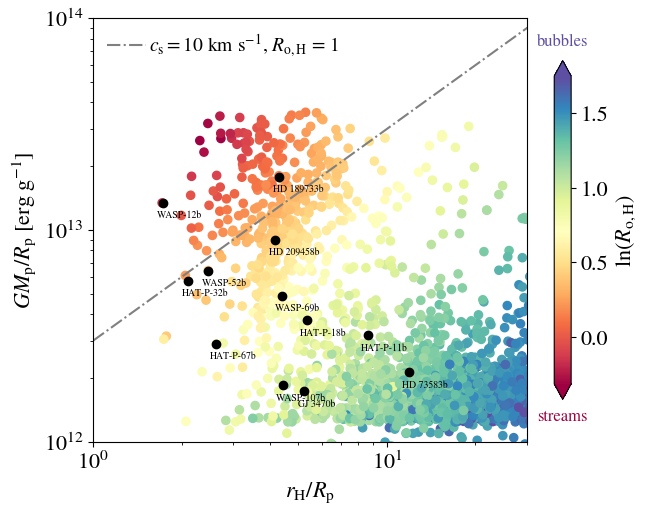

In [44]:
import pandas as pd

df = pd.read_csv('sunset_overview.csv',comment='#')
#for k in df.keys():
#    print(k)

dfs = df[["pl_name","pl_orbper","pl_orbsmax","pl_radj","pl_bmassj","st_teff","st_rad","st_mass","Mdot","T","mu_bar"]].copy()


plmass = dfs['pl_bmassj']*1.9e30 # g
plrad  = dfs['pl_radj']*7.14e9   #cm
sma    = dfs['pl_orbsmax']*1.49e13 # au
stmass = dfs['st_mass']*2e33      # g
temp   = dfs['T'] #K
mu     = dfs['mu_bar']

yaxis_value = 6.67e-8*plmass/plrad  # GM/R

rH = (plmass/(3*stmass))**(1/3.) * sma
xaxis_value = rH/plrad

cs2 = (5/3) * 1.38e-16*temp/(mu*1.67e-24)
lamH =  6.67e-8*plmass/(rH *cs2) 

rossby = np.sqrt(3/lamH)

sel = plrad > 1.6*6.37e8

plt.figure(figsize=(7,5.5))


cm = plt.cm.Spectral
sc = plt.scatter(xaxis_value[sel], yaxis_value[sel], c=np.log(rossby)[sel], s=35, cmap=cm,rasterized=True,vmax=1.75)
cbar=plt.colorbar(sc,extend='both',shrink=0.8)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel(r'$\ln(R_{\rm o,H})$')

#####################################################
# helium planets
name1 = np.array(['HAT-P-18b', 'HD 209458b', 'HD 189733b',  'WASP-69b', 'WASP-107b', 'HAT-P-32b', 'WASP-52b', 'HD 73583b', 'HAT-P-11b', 'GJ 3470b',  "WASP-12b", "HAT-P-67b"])
semimajor1  = np.array([0.0559,  0.047, 0.031,  0.045, 0.055, 0.0343, 0.027, 0.0604,  0.0525, 0.035,  0.0232, 0.06505])
pl_rad1  = np.array([0.95,1.36,  1.13,  1.057, 0.92, 1.789, 1.27, 0.25,  0.39, 0.41, 1.937, 2.085 ])
st_mass1  = np.array([0.77,  1.13, 0.84, 0.76, 0.683, 1.255, 0.853, 0.73, 0.77, 0.5,  1.4, 1.642 ])
pl_mass1  = np.array([ 0.20,  0.69, 1.13,  0.29, 0.096, 0.58, 0.46, 0.03, 0.07, 0.04, 1.465, 0.34])

xaxis1 = (semimajor1*1.49e13*pow(pl_mass1*1.9e30/(3*st_mass1*2.0e33), 1./3.0))/(pl_rad1*7.14e9)
yaxis1 = 6.67e-8*pl_mass1*1.9e30/(pl_rad1*7.14e9) 
plt.scatter(xaxis1, yaxis1, color='k',s=36)
for i in range(len(name1)):
	plt.text(0.95*xaxis1[i], 0.85*yaxis1[i], name1[i], color='black', fontsize=7)
######################################################

x_rratio = np.linspace(1.0, 1000, 100)
y_cs10 = 3 * (1e6/1)**2 * x_rratio # cs = 10, Ro = 1
plt.loglog(x_rratio, y_cs10, label=r'$c_\mathrm{s} = 10$ km s$^{-1}$, $R_{\rm o,H}$ = 1',ls='-.', color="grey")


plt.xlabel(r"$r_\mathrm{H}/R_\mathrm{p}$")
plt.ylabel("$GM_\mathrm{p}/R_\mathrm{p}$ [erg g$^{-1}$]")
plt.legend(loc=2, frameon=False)
plt.xlim(1.0, 30.0)
plt.ylim(1.0e12, 1.0e14)


cbar.ax.text(0.5, 1.1, 'bubbles', ha='center', transform=cbar.ax.transAxes,fontsize=12,color=cm(0.999))
cbar.ax.text(0.5, -0.12, 'streams', ha='center', transform=cbar.ax.transAxes,fontsize=12,color=cm(0.001))



plt.savefig("figures/exoplanets.pdf",bbox_inches='tight',dpi=150)